In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.linear_model import LogisticRegression

In [2]:
# read in cleaned CSV
filepath = Path('massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=15000)

In [3]:
massive.head(1)

,title,criticName,publicatioName,reviewText,scoreSentiment,delta
199548,Just Mercy,Rolando Gallego,EscribiendoCine,An important film that unfortunately falls int...,NEGATIVE,-14.0


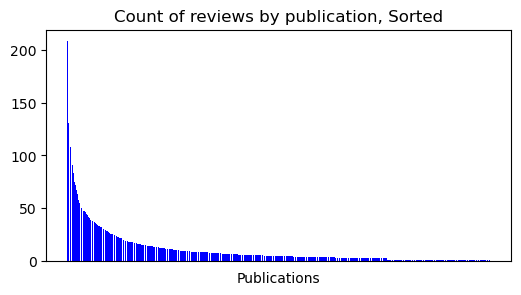

In [5]:
# Sort the 'publicatioName' column
publication_sorted = massive['publicatioName'].value_counts().reset_index().rename(
    columns={'index': 'publicatioName', 'publicatioName': 'count'})
publication_sorted = publication_sorted.sort_values(by='count', ascending=False)

# Set the figure size
plt.figure(figsize=(6, 3))

# Create a bar plot using Matplotlib
plt.bar(publication_sorted['publicatioName'], publication_sorted['count'], color='blue')

# Set the title
plt.title('Count of reviews by publication, Sorted')

# Remove x-axis labels
plt.xticks([])

# Set the x and y-axis labels
plt.xlabel('Publications')
plt.ylabel('')

# Save the plot as an image
plt.savefig("output_plots/histo_publicatioName.png")

# Show the plot
plt.show()








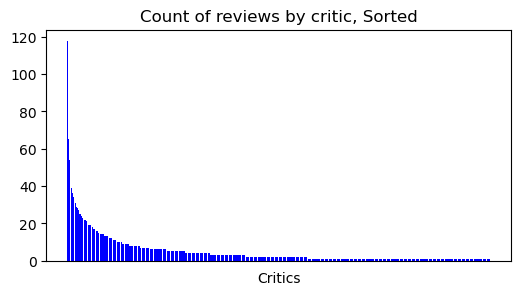

In [6]:
# Sort the 'criticName' column
critic_sorted = massive['criticName'].value_counts().reset_index().rename(
    columns={'index': 'criticName', 'criticName': 'count'})
critic_sorted = critic_sorted.sort_values(by='count', ascending=False)

# Set the figure size
plt.figure(figsize=(6, 3))

# Create a bar plot using Matplotlib
plt.bar(critic_sorted['criticName'], critic_sorted['count'], color='blue')

# Set the title
plt.title('Count of reviews by critic, Sorted')

# Remove x-axis labels
plt.xticks([])

# Set the x and y-axis labels
plt.xlabel('Critics')
plt.ylabel('')

# Save the plot as an image
plt.savefig("output_plots/histo_criticName.png")

# Show the plot
plt.show()


In [171]:
# define a function to process text on the data
lemmatizer = WordNetLemmatizer()
import re
def process_text(text): 
    sw = set(stopwords.words('english')) 
    regex = re.compile("[^a-zA-Z ]") 
    re_clean = regex.sub('', text) 
    words = word_tokenize(re_clean) 
    lem = [lemmatizer.lemmatize(word) for word in words] 
    output = ' '.join([word.lower() for word in lem if word.lower() not in sw]) 
    return output

In [172]:
# use a lambda x function to apply process text on the whole column.
massive['reviewText'] = massive['reviewText'].apply(lambda x: process_text(x))

In [174]:
# tfidf vectorizer for sentiment model
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(massive['reviewText'])
y = massive['scoreSentiment']

In [175]:
# Split the data into training and testing sets for sentiment model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Choose a machine learning model (e.g., Logistic Regression) and train it
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [176]:
model.score(X_train, y_train)

0.8205356348429576

In [177]:
model.score(X_test, y_test)

0.7531358420069388

In [178]:
# Creating a dataframe made of the vectorized review text for a linear model
massive_features = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())

C:\Users\Dan\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [179]:
massive_features.head(2)

,abandon,abandoned,ability,able,abrams,absent,absolute,absolutely,absorbing,absurd,...,youthful,youve,zack,zany,zeitgeist,zellweger,zemeckis,zero,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
# Need to rename because title is also a column in massive_features
massive = massive.rename(columns={'title': 'title_'})

In [200]:
# Vectorizing original df to dense array for linear model
tfidf_dense = tfidf_vectorizer.fit_transform(massive['reviewText']).todense()

# Naming columns for each vectorized word and combining with original dataframe
new_cols = tfidf_vectorizer.get_feature_names()
combined = massive.join(pd.DataFrame(tfidf_dense, columns=new_cols))

C:\Users\Dan\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [105]:
# Not using
# combined = pd.concat([massive, massive_features], axis=1)

In [201]:
# Dropping review text now that vectorized words are all columns
combined = combined.drop(columns=['reviewText'])
combined.head(1)

,title_,audienceScore,criticName,publicatioName,scoreSentiment,delta,abandon,abandoned,ability,able,...,youthful,youve,zack,zany,zeitgeist,zellweger,zemeckis,zero,zombie,zone
584840,My Name Is Hmmm...,36.0,Cath Clarke,Time Out,NEGATIVE,-14.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
combined = combined.fillna(0)

In [205]:
combined.isnull().sum().head(9)

title_            0
audienceScore     0
criticName        0
publicatioName    0
scoreSentiment    0
delta             0
abandon           0
abandoned         0
ability           0
dtype: int64

In [207]:
# Grouping bottom critics as Other to be encoded into one
counts = combined.criticName.value_counts()
threshold = combined.criticName.isin(counts.index[counts<16])
combined.loc[threshold, 'criticName'] = 'Other'
combined['criticName'].value_counts()

Other                  8954
Dennis Schwartz         103
Jeffrey M. Anderson      96
Roger Moore              85
Roger Ebert              73
                       ... 
Tim Robey                16
Michael O'Sullivan       16
Brian Viner              16
Eddie Harrison           16
Peter Debruge            16
Name: criticName, Length: 214, dtype: int64

In [211]:
# Repeat for publications
counts = combined.publicatioName.value_counts()
threshold = combined.publicatioName.isin(counts.index[counts<12])
combined.loc[threshold, 'publicatioName'] = 'Other'
combined['publicatioName'].value_counts()

Other                4185
New York Times        184
Variety               156
Slant Magazine        138
Los Angeles Times     132
                     ... 
RedEye                 12
Three Movie Buffs      12
That Shelf             12
SPLICEDWire            12
CultureMap             12
Name: publicatioName, Length: 328, dtype: int64

In [ ]:
# To Do:
Scale X data?
dummies
PCA
test train split after 

In [122]:
# columns to dummy
categorical_cols = ['title_', 'criticName', 'publicatioName', 'scoreSentiment'] 
# get dummies
combined = pd.get_dummies(combined, columns = categorical_cols)

In [113]:
X = combined.drop(columns=['delta'])
y = combined['delta']

In [114]:
X.isnull().sum()

title_            0
criticName        0
publicatioName    0
scoreSentiment    0
aaron             0
                 ..
zero              0
zodiac            0
zombie            0
zombies           0
zone              0
Length: 5004, dtype: int64

In [115]:
from sklearn.linear_model import LinearRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [116]:
X_train.isnull().sum()

title_            0
criticName        0
publicatioName    0
scoreSentiment    0
aaron             0
                 ..
zero              0
zodiac            0
zombie            0
zombies           0
zone              0
Length: 5004, dtype: int64

In [117]:
X_train.head()

,title_,criticName,publicatioName,scoreSentiment,aaron,abandon,abandoned,ability,able,ably,...,youth,youthful,youve,zany,zeitgeist,zero,zodiac,zombie,zombies,zone
448204,Narco cultura,Joe Neumaier,New York Daily News,NEGATIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762304,Diana,Nicholas Bell,IONCINEMA.com,NEGATIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
840540,Greta,Richard von Busack,"Pacific Sun (San Rafael, CA)",POSITIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47414,2046,Enrique Buchichio,Uruguay Total,POSITIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
875600,The Truth About Emanuel,Brian Orndorf,Blu-ray.com,POSITIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
X_train.tail()

,title_,criticName,publicatioName,scoreSentiment,aaron,abandon,abandoned,ability,able,ably,...,Deborah Henderson,Joe Utichi,Michael Bonner,Drew Gregory,Justin Hartung,Matt Bochenski,Meagan Navarro,Peg Aloi,Ron Wells,R. Kurt Osenlund
865392,From Hell,James Berardinelli,ReelViews,POSITIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
763566,Our Daily Bread,Leo Goldsmith,Not Coming to a Theater Near You,POSITIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
48191,Spider-Man 2,Andy Klein,Los Angeles CityBeat,POSITIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
11786,The Son of No One,R. Kurt Osenlund,Slant Magazine,POSITIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
543751,Kill Bill: Vol. 1,Paul Byrnes,Sydney Morning Herald,NEGATIVE,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
# Choose a machine learning model (e.g., Logistic Regression) and train it
model = LinearRegression()
model.fit(X_train_coded, y_train)

LinearRegression()

In [125]:
model.score(X_test_coded, y_test)

C:\Users\Dan\anaconda3\envs\nlp\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- criticName_A.D. Murphy
- criticName_Aaron Lazenby
- criticName_Abby Garnett
- criticName_Adam Lippe
- criticName_Adrián Monserrat
- ...
Feature names seen at fit time, yet now missing:
- criticName_ Anjolie Therrien
- criticName_A.C. Koch
- criticName_A.S. Hamrah
- criticName_AJ Caulfield
- criticName_AP Kryza
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 10553 features, but LinearRegression is expecting 15602 features as input.